In [1]:
%pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
albumentations               1.3.1
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.1
certifi                      2023.5.7
charset-normalizer           3.1.0
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
executing                    1.2.0
filelock                     3.12.2
flatbuffers                  23.5.26
fonttools                    4.40.0
gast                         0.4.0
google-auth                  2.20.0
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.56.0
h5py                         3.9.0
idna                         3.4
imageio                      2.31.1
ipyke

# LOAD DATA

SETUP/IMPORTS

In [2]:
import tensorflow as tf

import os
import shutil

import cv2
import imghdr

from matplotlib import pyplot as plt
import numpy as np

from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.metrics import Precision, Recall, BinaryAccuracy

C:\Users\Akshay\AppData\Local\Temp\ipykernel_14504\4065632612.py:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


MEMORY LIMITER

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

PATH/VARIABLE NAMES

In [5]:
data_path = './data/'
img_extensions = ['jpeg', 'jpg', 'bmp', 'png']

REMOVE BUGGY IMAGES

In [6]:
for image_type in os.listdir(data_path):
    for image in os.listdir(os.path.join(data_path, image_type)):
        image_path = os.path.join(data_path, image_type, image)
        try:
            img = cv2.imread(image_path)
            ext = imghdr.what(image_path)

            if ext not in img_extensions:
                print (image_path + ' has unknown extension')
                os.remove(image_path)
        except:
            print (image_path + ' has reading error')
            os.remove(image_path)

LOAD DATA

In [7]:
#data pipline
data = tf.keras.utils.image_dataset_from_directory(data_path)

#loop through data pipeline
data_iterator = data.as_numpy_iterator()

#access data pipeline
batch = data_iterator.next()

#in a batch, [0] represents the images and [1] represents the labels/classification from the AI model
batch[0].shape
batch[1]

Found 200 files belonging to 2 classes.


array([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0])

SHOW DATA

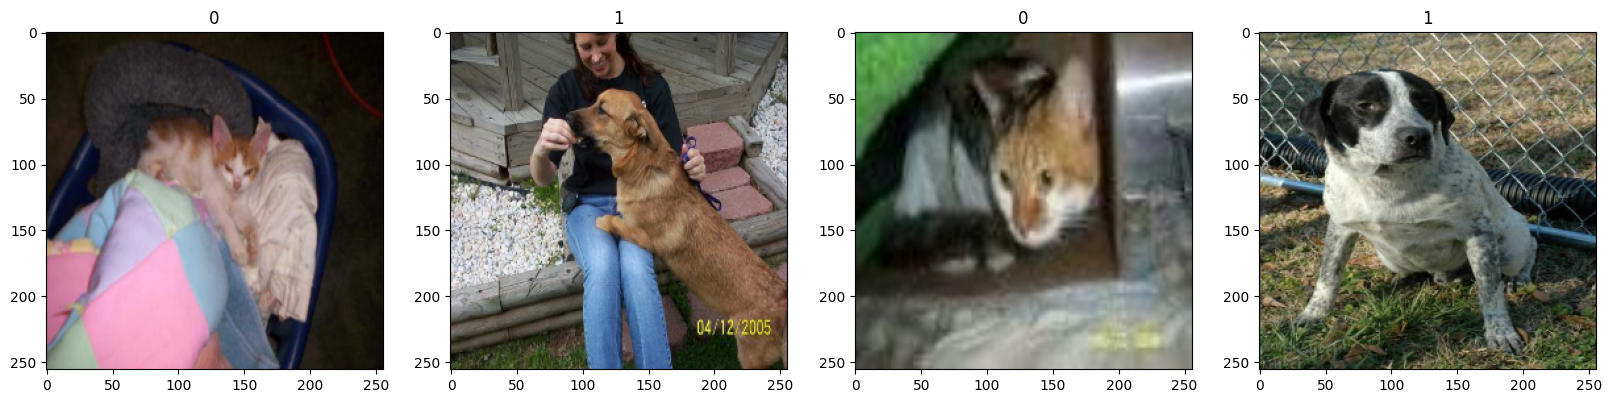

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# PREPROCESS DATA

SCALE DATA

Make all values of images between 0 and 1, apparently decreases workload of AI model.

In [9]:
scaled_data = data.map(lambda x, y: (x/255, y))

In [10]:
scaled_batch = scaled_data.as_numpy_iterator().next()
print("max: "+str(scaled_batch[0].max()))
print("min: "+str(scaled_batch[0].min()))

max: 1.0
min: 0.0


SPLIT DATA

Make training and validation data.

In [11]:
print(len(scaled_data))
train_size = int(len(scaled_data)*.7)
valid_size = int(len(scaled_data)*.2)
test_size = int(len(scaled_data)*.1)

print(train_size, valid_size, test_size)

7
4 1 0


In [12]:
train = data.take(train_size)
valid = data.skip(train_size).take(valid_size)
test = data.skip(train_size+valid_size).take(test_size)

print (train)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# DEEP MODEL

BUILD LEARNING MODEL

In [13]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
#BELOW ACTIVATION FUNCTION MIGHT CHANGE
model.add(Dense(1, activation='sigmoid'))   

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

TRAIN THE MODEL

In [14]:
logs_path = './logs/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_path)
history = model.fit(train, epochs=7, validation_data=valid, callbacks=[tensorboard_callback])

Epoch 1/7
4/4 [==============================] - 4s 828ms/step - loss: 146.7094 - accuracy: 0.5781 - val_loss: 11.8332 - val_accuracy: 0.6250
Epoch 2/7
4/4 [==============================] - 3s 750ms/step - loss: 7.8399 - accuracy: 0.5234 - val_loss: 1.7291 - val_accuracy: 0.3438
Epoch 3/7
4/4 [==============================] - 3s 743ms/step - loss: 0.8823 - accuracy: 0.5625 - val_loss: 0.4989 - val_accuracy: 0.6875
Epoch 4/7
4/4 [==============================] - 3s 802ms/step - loss: 0.4913 - accuracy: 0.7578 - val_loss: 0.4468 - val_accuracy: 0.7812
Epoch 5/7
4/4 [==============================] - 4s 871ms/step - loss: 0.3521 - accuracy: 0.8984 - val_loss: 0.2764 - val_accuracy: 0.8750
Epoch 6/7
4/4 [==============================] - 3s 854ms/step - loss: 0.2811 - accuracy: 0.8594 - val_loss: 0.1581 - val_accuracy: 1.0000
Epoch 7/7
4/4 [==============================] - 3s 853ms/step - loss: 0.2045 - accuracy: 0.9531 - val_loss: 0.1663 - val_accuracy: 0.9375


PLOT PERFORMANCE OF MODEL

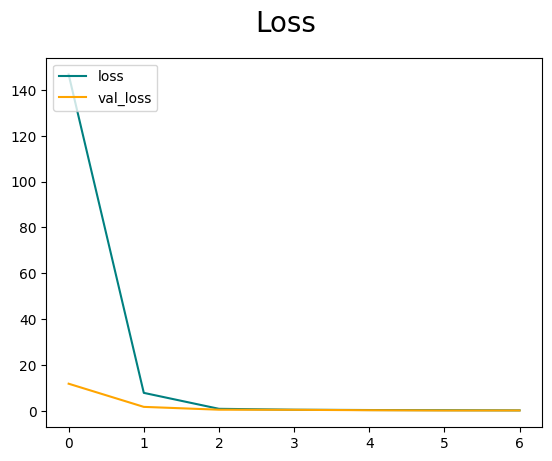

In [15]:
figure = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
figure.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

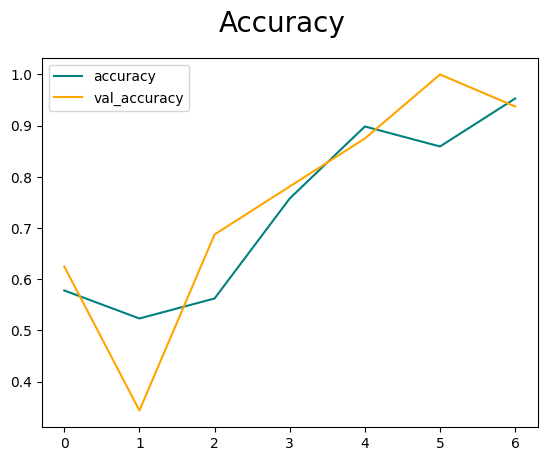

In [16]:
figure = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
figure.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# EVALUATE PERFORMANCE

EVALUATE

In [17]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')    

Precision:0.0, Recall:0.0, Accuracy:0.0


NEW DATA

In [18]:
#read image
new_img = cv2.imread('./data/cats/cat.0.jpg')
#plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
#plt.show()

#resize image
new_img_resized = tf.image.resize(new_img, (256, 256))
#plt.imshow(resize.numpy().astype(int))
#plt.show

prediction = model.predict(np.expand_dims(new_img_resized/255, 0))
print(prediction)

1/1 [==============================] - 0s 208ms/step
[[0.49572167]]


IMAGE CLASSIFIER

In [19]:
unsorted = './cats-vs-dogs/unsorted/'
cats = './cats-vs-dogs/cats/'
dogs = './cats-vs-dogs/dogs/'

for images in os.listdir(unsorted):
    new_img = cv2.imread(os.path.join(unsorted, images))
    new_img_resized = tf.image.resize(new_img, (256, 256))

    if model.predict(np.expand_dims(new_img_resized/255, 0)) < 0.5:
        shutil.move(os.path.join(unsorted, images), cats)
    else:
        shutil.move(os.path.join(unsorted, images), dogs)

1/1 [==============================] - 0s 46ms/step


# SAVE MODEL

In [20]:
model.save('CvD-Model.h5')